<a href="https://colab.research.google.com/github/elan-wilkinson/CV-Prediction-of-Ocular-Disease/blob/main/Copy20231203_CV_to_Predict_Ocular_Disease_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# MSAAI-501 Intro to Artificial Intelligence
# Group 3 Final Project - Using Computer Vision to Predict Ocular Disease

Team Members:
  Elan Wilkinson,
  Ben Hopwood,
  Sarah Durrani


### Data Source and Description:

Date Source:
Maranhão, A. (2020, September 24). Ocular Disease Recognition: Right and left eye fundus photographs of 5000 patients. Kaggle. https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k  

Project Desciption: This project explored taking a fundal image to classify it as appearing healthy or indicative of:
  - diabetes
  - glaucoma
  - cataracts
  - age-related macular degeneration
  - hypertension
  - pathological myopia
  - or other diseases/concerns.
  
This team explored multiple approaches to determine which solution provides the best classification results. These include Convoluted Neural Networks (CNN), Residual Neural Networks (RNN), Support Vector Machines, YOLO, and ResNet. The project estimated the category of disease a fundal image would fall into and give a measure of the agent’s confidence in the classification. While accuracy and precision are paramount metrics to base performance on, the speed/memory required to perform the calculations was also considered.



### **The Basics:**

In [30]:
#import libraries
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import tkinter as tk #no longer needed
from tkinter import filedialog #no longer needed

from PIL import Image
import zipfile
from PIL import Image
import io
import re

import shutil
import logging


import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
# import efficientnet.tfkeras as efn.    # issues importing, may not be neeeded
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input



In [ ]:
""" This code was used by Ben to open images outside of Google Collab - Not likely needed

## Find the file for the Main dataframe
# Initialize the Tkinter root
root = tk.Tk()
root.withdraw()

# Show a "Select File" dialog box and return the path to the selected file
# User should select the 'data.xlsx' spreadsheet, likley in ../ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx
file_path = filedialog.askopenfilename(title="Select Excel File")

# Check if a folder was selected
if file_path:
    print("Selected file:", file_path)
else:
    # This block executes if the user didn't select a folder
    print("User did not select a file, cannot proceed. Please retry.")
"""

' This code was used by Ben to open images outside of Google Collab - Not likely needed\n\n## Find the file for the Main dataframe\n# Initialize the Tkinter root\nroot = tk.Tk()\nroot.withdraw() \n\n# Show a "Select File" dialog box and return the path to the selected file\n# User should select the \'data.xlsx\' spreadsheet, likley in ../ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx\nfile_path = filedialog.askopenfilename(title="Select Excel File")\n\n# Check if a folder was selected\nif file_path:\n    print("Selected file:", file_path)\nelse:\n    # This block executes if the user didn\'t select a folder\n    print("User did not select a file, cannot proceed. Please retry.")\n'

In [ ]:
""" This code was used by Ben to open images outside of Google Collab - Not likely needed

## Find the folder for the pre-processed images
# Initialize the Tkinter root
root = tk.Tk()
root.withdraw()

# Show a "Select Folder" dialog box and return the path to the selected folder
# User should select the pre-processed images folder, likley in ../ocular-disease-recognition-odir5k/preprocessed_images
Image_dir_root = filedialog.askdirectory(title="Select Image Directory")

# Check if a folder was selected
if Image_dir_root :
    print("Selected folder:", Image_dir_root)
else:
    # This block executes if the user didn't select a folder
    print("User did not select a folder, cannot proceed. Please retry.")
"""

' This code was used by Ben to open images outside of Google Collab - Not likely needed\n\n## Find the folder for the pre-processed images\n# Initialize the Tkinter root\nroot = tk.Tk()\nroot.withdraw() \n\n# Show a "Select Folder" dialog box and return the path to the selected folder\n# User should select the pre-processed images folder, likley in ../ocular-disease-recognition-odir5k/preprocessed_images\nImage_dir_root = filedialog.askdirectory(title="Select Image Directory")\n\n# Check if a folder was selected\nif Image_dir_root :\n    print("Selected folder:", Image_dir_root)\nelse:\n    # This block executes if the user didn\'t select a folder\n    print("User did not select a folder, cannot proceed. Please retry.")\n'

### **Importing Data: (Note - filepaths will need adjustment for individual use)**

> Indented block



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# These are the paths to the dataset folders on you local machine [ADJUST T0 YOUR PATHS].
File_path = '/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/data_processed.xlsx'
Image_dir_root = '/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/preprocessed_images'

train_base_dir = "/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/train" #this folder may need to be created
image_dir = "/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/preprocessed_images"

In [62]:
#Structure the image and dataframe directories

# Create a DataFrame from the Excel file
ocular_data = pd.read_excel(File_path)

ocular_data.head(5)


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Left-N,Right-N,N,...,A,Left-H,Right-H,H,Left-M,Right-M,M,Left-O,Right-O,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
"""First attempt - can delete

#One Shot Encoding for each fundus image

# Create relevant columns for both Left and Right images
column_suffixes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for suffix in column_suffixes:
    ocular_data[f'Left-{suffix}'] = 0
    ocular_data[f'Right-{suffix}'] = 0


def OneShotEncode(index):
    left_keywords = ocular_data.at[index, 'Left-Diagnostic Keywords']
    right_keywords = ocular_data.at[index, 'Right-Diagnostic Keywords']

    # Resetting the one-shot encoding for this index
    for suffix in column_suffixes:
        ocular_data.at[index, f'Left-{suffix}'] = 0
        ocular_data.at[index, f'Right-{suffix}'] = 0

    # One-Shot encoding column for Left keywords
    if "normal" in left_keywords:
        ocular_data.at[index, 'Left-N'] = 1
    elif "retinopathy" in left_keywords:
        ocular_data.at[index, 'Left-D'] = 1
    elif "glaucoma" in left_keywords:
        ocular_data.at[index, 'Left-G'] = 1
    elif "cataract" in left_keywords:
        ocular_data.at[index, 'Left-C'] = 1
    elif "macular degeneration" in left_keywords:
        ocular_data.at[index, 'Left-A'] = 1
    elif "hypertensive" in left_keywords:
        ocular_data.at[index, 'Left-H'] = 1
    elif "myopia" in left_keywords:
        ocular_data.at[index, 'Left-M'] = 1
    else:
        ocular_data.at[index, 'Left-O'] = 1

    # One-Shot encoding column for Right keywords
    if "normal" in right_keywords:
        ocular_data.at[index, 'Right-N'] = 1
    elif "retinopathy" in right_keywords:
        ocular_data.at[index, 'Right-D'] = 1
    elif "glaucoma" in right_keywords:
        ocular_data.at[index, 'Right-G'] = 1
    elif "cataract" in right_keywords:
        ocular_data.at[index, 'Right-C'] = 1
    elif "macular degeneration" in right_keywords:
        ocular_data.at[index, 'Right-A'] = 1
    elif "hypertensive" in right_keywords:
        ocular_data.at[index, 'Right-H'] = 1
    elif "myopia" in right_keywords:
        ocular_data.at[index, 'Right-M'] = 1
    else:
        ocular_data.at[index, 'Right-O'] = 1

# Execute One Shot Encoding
for i in range(len(ocular_data)):
    OneShotEncode(i)

ocular_data.head(20)

"""

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Structure images into directories

In [ ]:
""" Code was messy tried to generalize better

#One Shot Encoding for each fundus image

#create training file path as needed
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)
for categ in categs:
    if not os.path.exists(os.path.join(train_base_dir, categ)):
        os.mkdir(os.path.join(train_base_dir, categ))



# Create relevant columns for both Left and Right images
for suffix in categs:
    ocular_data[f'Left-{suffix}'] = 0
    ocular_data[f'Right-{suffix}'] = 0


# call to take file and move into folder structure for training model(s)
def MoveImgToTraining(directory, file_name, destination):
    if os.path.exists(os.path.join(directory, file_name)):
        shutil.copy(os.path.join(directory, file_name), os.path.join(destination, file_name))

# function to loop over dataframe, encode if disease state is present, and pass images to training
def OneShotEncode(index):
    # Resetting the one-shot encoding for this index
    for suffix in categs:
        ocular_data.at[index, f'Left-{suffix}'] = 0
        ocular_data.at[index, f'Right-{suffix}'] = 0
    #begin one shot encoding
        left_keywords = ocular_data.at[index, 'Left-Diagnostic Keywords'].lower()
        right_keywords = ocular_data.at[index, 'Right-Diagnostic Keywords'].lower()
        l_file = str(index) + "_left.jpg" #left fundus image file name
        r_file = str(index)+ "_right.jpg" #right fundus image file name
        # One-Shot encoding column for Left keywords
        if "normal" in left_keywords:
            ocular_data.at[index, 'Left-N'] = 1 #one shot encode in into dataframe
            ldest = train_base_dir + "\\N\\" # file destination
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "retinopathy" in left_keywords:
            ocular_data.at[index, 'Left-D'] = 1
            ldest = train_base_dir + "\\D\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "glaucoma" in left_keywords:
            ocular_data.at[index, 'Left-G'] = 1
            ldest = train_base_dir + "\\G\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "cataract" in left_keywords:
            ocular_data.at[index, 'Left-C'] = 1
            ldest = train_base_dir + "\\C\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "macular degeneration" in left_keywords:
            ocular_data.at[index, 'Left-A'] = 1
            ldest = train_base_dir + "\\A\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "hypertensive" in left_keywords:
            ocular_data.at[index, 'Left-H'] = 1
            ldest = train_base_dir + "\\H\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        elif "myopia" in left_keywords:
            ocular_data.at[index, 'Left-M'] = 1
            ldest = train_base_dir + "\\M\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        else:
            ocular_data.at[index, 'Left-O'] = 1
            ldest = train_base_dir + "\\O\\"
            MoveImgToTraining(train_base_dir, l_file, ldest)
        # One-Shot encoding column for Right keywords
        if "normal" in right_keywords:
            ocular_data.at[index, 'Right-N'] = 1
            rdest = train_base_dir + "\\N\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "retinopathy" in right_keywords:
            ocular_data.at[index, 'Right-D'] = 1
            rdest = train_base_dir + "\\D\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "glaucoma" in right_keywords:
            ocular_data.at[index, 'Right-G'] = 1
            rdest = train_base_dir + "\\G\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "cataract" in right_keywords:
            ocular_data.at[index, 'Right-C'] = 1
            rdest = train_base_dir + "\\C\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "macular degeneration" in right_keywords:
            ocular_data.at[index, 'Right-A'] = 1
            rdest = train_base_dir + "\\A\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "hypertensive" in right_keywords:
            ocular_data.at[index, 'Right-H'] = 1
            rdest = train_base_dir + "\\H\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        elif "myopia" in right_keywords:
            ocular_data.at[index, 'Right-M'] = 1
            rdest = train_base_dir + "\\M\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)
        else:
            ocular_data.at[index, 'Right-O'] = 1
            rdest = train_base_dir + "\\O\\"
            MoveImgToTraining(train_base_dir, r_file, rdest)


# Execute One Shot Encoding
for i in range(len(ocular_data)):
    OneShotEncode(i)

ocular_data.head(20)
"""

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Pre-processing

In [52]:
#create training file path as needed
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)
for categ in categs:
    if not os.path.exists(os.path.join(train_base_dir, categ)):
        os.mkdir(os.path.join(train_base_dir, categ))

# dictionary of words used to one shot encode
keyword_map = {
    'N': 'normal',
    'D': 'retinopathy',
    'G': 'glaucoma',
    'C': 'cataract',
    'A': 'macular degeneration',
    'H': 'hypertensive',
    'M': 'myopia',
    'O': 'other'  # 'other' is a catch-all category for keywords not covered by other categories
}


# Regular expression pattern to match special characters
special_char_pattern = r"[^a-zA-Z0-9\s]"

def remove_special_characters(keywords):
    return re.sub(special_char_pattern, "", keywords)


# Apply the cleaning function to both Left and Right Diagnostic Keywords columns
ocular_data['Left-Keyword-Set'] = ocular_data['Left-Diagnostic Keywords'].astype(str).apply(remove_special_characters)
ocular_data['Right-Keyword-Set'] = ocular_data['Right-Diagnostic Keywords'].astype(str).apply(remove_special_characters)


# Create relevant columns for both Left and Right images
for suffix in categs:
    ocular_data[f'Left-{suffix}'] = 0
    ocular_data[f'Right-{suffix}'] = 0

In [ ]:
#create training file path as needed
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)
for categ in categs:
    if not os.path.exists(os.path.join(train_base_dir, categ)):
        os.mkdir(os.path.join(train_base_dir, categ))




#Sorts images into training folders based on one hot encoding
def SortOneHotEncodingsForTraining(index, LeftOrRight, ocular_data, train_base_dir, image_dir):
    file_ID = ocular_data.at[index, 'ID']
    file_name = f"{file_ID}_{LeftOrRight.lower()}.jpg"
    for suffix in categs:
        if ocular_data.at[index, f'{LeftOrRight}-{suffix}'] == 1:
            destination = os.path.join(train_base_dir, suffix)
            MoveImgToTraining(image_dir, file_name, destination)




# Take file and move into folder structure for training model(s)
def MoveImgToTraining(directory, file_name, destination):
    source_path = os.path.join(directory, file_name)
    destination_path = os.path.join(destination, file_name)
    try:
        # Check if the source file exists
        if not os.path.exists(source_path):
            logging.info(f"Source file not found: {source_path}")
            return False
        # Ensure destination directory exists
        if not os.path.exists(destination):
            os.makedirs(destination)
        # Perform the file copy
        shutil.copy(source_path, destination_path)
        logging.info(f"Successfully moved {file_name} to {destination_path}")
        return True
    except PermissionError:
        logging.info(f"Permission denied: Cannot move {file_name} to {destination_path}")
        return False
    except IOError as e:
        logging.info(f"IO error occurred: {e}")
        return False
    except Exception as e:
        logging.info(f"An unexpected error occurred: {e}")
        return False

In [58]:
""" Too many mistakes. Just ended up sorting in Excel in 100th the time...

#create training file path as needed
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)
for categ in categs:
    if not os.path.exists(os.path.join(train_base_dir, categ)):
        os.mkdir(os.path.join(train_base_dir, categ))

# dictionary of words used to one shot encode
keyword_map = {
    'N': 'normal',
    'D': 'retinopathy',
    'G': 'glaucoma',
    'C': 'cataract',
    'A': 'macular degeneration',
    'H': 'hypertensive',
    'M': 'myopia',
    'O': 'other'  # 'other' is a catch-all category for keywords not covered by other categories
}


# Regular expression pattern to match special characters
special_char_pattern = r"[^a-zA-Z0-9\s]"

def remove_special_characters(keywords):
    return re.sub(special_char_pattern, "", keywords)


# Apply the cleaning function to both Left and Right Diagnostic Keywords columns
ocular_data['Left-Keyword-Set'] = ocular_data['Left-Diagnostic Keywords'].astype(str).apply(remove_special_characters)
ocular_data['Right-Keyword-Set'] = ocular_data['Right-Diagnostic Keywords'].astype(str).apply(remove_special_characters)


# Create relevant columns for both Left and Right images
for suffix in categs:
    ocular_data[f'Left-{suffix}'] = 0
    ocular_data[f'Right-{suffix}'] = 0

#One Shot Encoding for each fundus image

# call to take file and move into folder structure for training model(s)
def MoveImgToTraining(directory, file_name, destination):
    source_path = os.path.join(directory, file_name)
    destination_path = os.path.join(destination, file_name)
    try:
        # Check if the source file exists
        if not os.path.exists(source_path):
            logging.info(f"Source file not found: {source_path}")
            return False
        # Ensure destination directory exists
        if not os.path.exists(destination):
            os.makedirs(destination)
        # Perform the file copy
        shutil.copy(source_path, destination_path)
        logging.info(f"Successfully moved {file_name} to {destination_path}")
        return True
    except PermissionError:
        logging.info(f"Permission denied: Cannot move {file_name} to {destination_path}")
        return False
    except IOError as e:
        logging.info(f"IO error occurred: {e}")
        return False
    except Exception as e:
        logging.info(f"An unexpected error occurred: {e}")
        return False



def process_image_keywords(index, LeftOrRight):
    # Use the cleaned keywords string
    cleaned_keywords = ocular_data.at[index, f'{LeftOrRight}-Keyword-Set']

    file_ID = ocular_data.at[index, 'ID']
    file_name = f"{file_ID}_{LeftOrRight.lower()}.jpg"
    category_matched = False

    for suffix in categs:
        # Check if any keyword in the cleaned string matches the category
        if any(keyword in cleaned_keywords for keyword in keyword_map[suffix]):
            ocular_data.at[index, f'{LeftOrRight}-{suffix}'] = 1
            destination = os.path.join(train_base_dir, suffix)
            MoveImgToTraining(image_dir, file_name, destination)
            category_matched = True
            break

    if not category_matched:
        ocular_data.at[index, f'{LeftOrRight}-O'] = 1
        destination = os.path.join(train_base_dir, "O")
        MoveImgToTraining(image_dir, file_name, destination)




# function to loop over dataframe, encode if disease state is present, and pass images to training
def OneShotEncode(index):
    # Resetting the one-shot encoding for this index
    for suffix in categs:
        ocular_data.at[index, f'Left-{suffix}'] = 0
        ocular_data.at[index, f'Right-{suffix}'] = 0
    # Process for both Left and Right images
    process_image_keywords(index, 'Left')
    process_image_keywords(index, 'Right')


# Execute One Shot Encoding
#for i in range(len(ocular_data)):
 #   OneShotEncode(i)

ocular_data.head(20)

"""

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Not sure if needed any more - delete
"""


# Adding in filepaths to the images assocuated with left and right fundus images
Main_df['left-filepath'] = Main_df['Left-Fundus'].apply(lambda x: os.path.join(Image_dir_root, str(x)))
Main_df['right-filepath'] = Main_df['Right-Fundus'].apply(lambda x: os.path.join(Image_dir_root, str(x)))


# Check if the image files exist (optional?)
Main_df['left-filepath_exists'] = Main_df['left-filepath'].apply(os.path.exists)
Main_df['right-filepath_exists'] = Main_df['right-filepath'].apply(os.path.exists)


Main_df.head(20)


### Need to identify which individual fundus has normal/cataract/etc... We don't want to train a HEALTHY left fundus as dieseased based on a DISEASED right fundus
#  Perhaps this is in Elans's VGG attempts already????

"""

"\n\n\n# Adding in filepaths to the images assocuated with left and right fundus images\nMain_df['left-filepath'] = Main_df['Left-Fundus'].apply(lambda x: os.path.join(Image_dir_root, str(x)))\nMain_df['right-filepath'] = Main_df['Right-Fundus'].apply(lambda x: os.path.join(Image_dir_root, str(x)))\n\n\n# Check if the image files exist (optional?)\nMain_df['left-filepath_exists'] = Main_df['left-filepath'].apply(os.path.exists)\nMain_df['right-filepath_exists'] = Main_df['right-filepath'].apply(os.path.exists)\n\n\nMain_df.head(20)\n\n\n### Need to identify which individual fundus has normal/cataract/etc... We don't want to train a HEALTHY left fundus as dieseased based on a DISEASED right fundus\n#  Perhaps this is in Elans's VGG attempts already????\n\n"

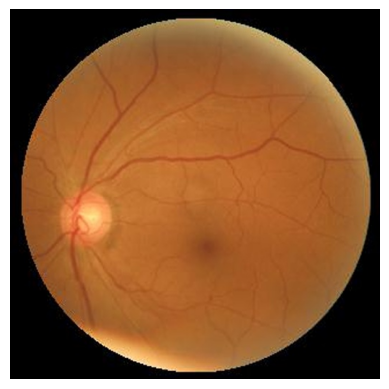

"\n# Read each image and add it to the DataFrame \nfor index, row in Main_df.iterrows():\n    # Example for left eye images, you would do something similar for right eye images\n    left_img_path = row['left-filepath']\n    if os.path.exists(left_img_path):  # Check if the file exists\n        img = Image.open(left_img_path)\n        Main_df.at[index, 'Left_Image'] = img\n"

In [ ]:
''' Debug code, used to try on one image

#Add images into the dataframe
Main_df['Left_Image']=None
Main_df['Right_Image']=None


index_to_load = 3
left_img_path = Main_df.at[index_to_load, 'left-filepath']

# Check if the file exists
if os.path.exists(left_img_path):
    # Open the image and load it into the DataFrame
    img = Image.open(left_img_path)
    Main_df.at[index_to_load, 'Left_Image'] = img
else:
    print(f"The image at {left_img_path} does not exist.")



# Assuming Main_df and the image at index 3 have been loaded as per previous instructions

# Retrieve the image object from the DataFrame
image_to_display = Main_df.at[3, 'Left_Image']

# Display the image
plt.imshow(image_to_display)
plt.axis('off')  # Hide the axis
plt.show()

'''

In [ ]:
"""
### This code to be deleted - took WAY too long to load

#Add images into the dataframe
Main_df['Left_Image']=None
Main_df['Right_Image']=None


# Read each image and add it to the DataFrame
for index, row in Main_df.iterrows():
    left_img_path = row['left-filepath']
    right_img_path = row['right-filepath']
    if os.path.exists(left_img_path):  # Check if the file exists
        img_left = Image.open(left_img_path)
        Main_df.at[index, 'Left_Image'] = img_left
    if os.path.exists(right_img_path):  # Check if the file exists
        img_right = Image.open(right_img_path)
        Main_df.at[index, 'Right_Image'] = img_right
"""



"\n### This code to be deleted - took WAY too long to load\n\n#Add images into the dataframe\nMain_df['Left_Image']=None\nMain_df['Right_Image']=None\n\n\n# Read each image and add it to the DataFrame \nfor index, row in Main_df.iterrows():\n    left_img_path = row['left-filepath']\n    right_img_path = row['right-filepath']\n    if os.path.exists(left_img_path):  # Check if the file exists\n        img_left = Image.open(left_img_path)\n        Main_df.at[index, 'Left_Image'] = img_left\n    if os.path.exists(right_img_path):  # Check if the file exists\n        img_right = Image.open(right_img_path)\n        Main_df.at[index, 'Right_Image'] = img_right\n"

In [ ]:
# loading in images above took a long time... 23 min

In [ ]:
""" Not ready to plt yet, but here's code from https://www.kaggle.com/code/koshirosato/cataract-classification-with-two-retina-datasets/notebook
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()
"""

In [ ]:
#this one took 30 seconds...

In [ ]:
#Load in Images

# Unzipping the folder
zip_path = '/content/drive/MyDrive/Colab Notebooks/ocular-disease-recognition-odir5k/preprocessed_images.zip'  # Adjust this if your path is different
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# Loading images into a dataframe
images_directory = '/content/preprocessed_images'  # Adjust the path if necessary
images_data = []

for filename in os.listdir(images_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other file types if needed
        filepath = os.path.join(images_directory, filename)
        with open(filepath, 'rb') as image_file:
            image = Image.open(image_file)
            image_bytes = io.BytesIO()
            image.save(image_bytes, format=image.format)
            image_data = image_bytes.getvalue()
            images_data.append({'filename': filename, 'image': image_data})

df_images = pd.DataFrame(images_data)

print(df_images.head())  # This will print the first few rows of the dataframe


         filename                                              image
0  3173_right.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1   4428_left.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2   727_right.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3  4199_right.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4   892_right.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


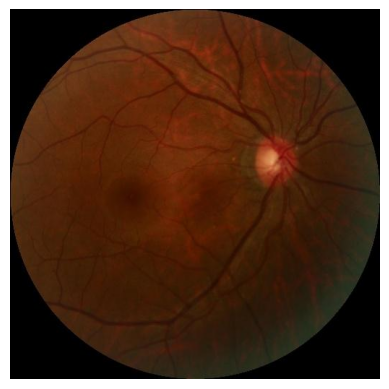

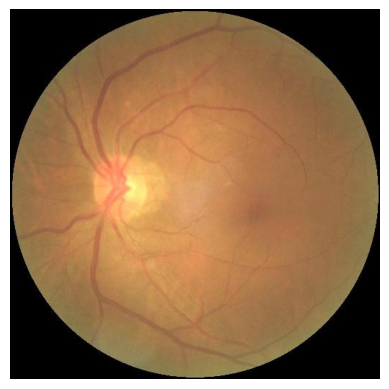

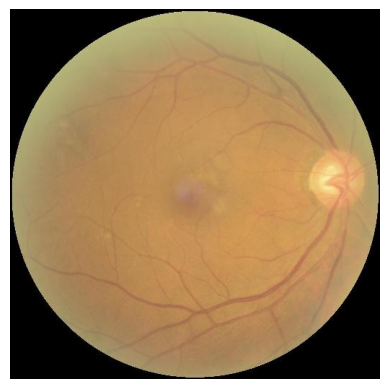

In [ ]:
def display_image_from_bytes(bytes_data):
    image = Image.open(io.BytesIO(bytes_data))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Display the first three images
for index, row in df_images.head(3).iterrows():
    display_image_from_bytes(row['image'])

In [ ]:
# Initialize new columns for the images
Main_df['Left-Image'] = None
Main_df['Right-Image'] = None

# Function to get image data from df_images
def get_image_data(filename):
    if filename in df_images['filename'].values:
        return df_images.loc[df_images['filename'] == filename, 'image'].iloc[0]
    else:
        return None

# Loop through Main_df and populate the new columns
for index, row in Main_df.iterrows():
    left_image_name = row['Left-Fundus']
    right_image_name = row['Right-Fundus']

    # Get image data for left and right images
    Main_df.at[index, 'Left-Image'] = get_image_data(left_image_name)
    Main_df.at[index, 'Right-Image'] = get_image_data(right_image_name)

# Display the first few rows of the updated Main_df
print(Main_df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  ...  Left-A  Right-A  \
0                           normal fundus  0  0  0  ...       0        0   
1                           normal fundus  1  0  0  ...       0        0   
2  moderate non proliferative retinopathy  0  1  0  ...       0        0   
3   

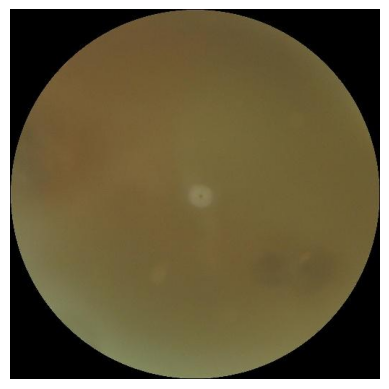

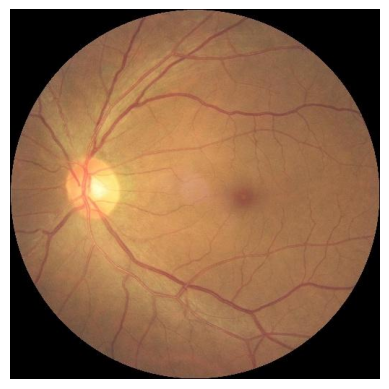

UnidentifiedImageError: ignored

In [ ]:
# Display the first three images
for index, row in Main_df.head(3).iterrows():
    display_image_from_bytes(row['Left-Image'])

### **Distribution of Data:**


###**Splitting into Test Train Datasets:**

###**??? VGG16 Example???:**

> Indented block



###**??? VGG19 Example???:**

###**??? CNN Example???:**

###**??? SVM Example???:** - yes failing is okay